## Setup

In [1]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Model

In [4]:
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

2024-05-23 15:44:01.858296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 15:44:01.858401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 15:44:01.972737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
processor = DPTImageProcessor.from_pretrained("Intel/dpt-swinv2-tiny-256")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-swinv2-tiny-256").to('cuda')

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/164M [00:00<?, ?B/s]

In [6]:
model.eval()

DPTForDepthEstimation(
  (backbone): Swinv2Backbone(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, 

In [7]:
config ={
    "General":{
        "device":"cuda",
        "type":"full",
        "model": model,
        "emb_dim":768,
        "hooks":[2, 5, 8, 11],
        "read":"projection",
        "resample_dim":256,
        "optim":"adam",
        "lr_backbone":1e-5,
        "lr_scratch":3e-4,
        "loss_depth":"ssi",
        "loss_segmentation":"ce",
        "momentum":0.9,
        "epochs":3,
        "batch_size":1,
        "path_model":"models",
        "path_predicted_images":"output",
        "seed":0,
        "patch_size":16
    },
    "Dataset":{
        "paths":{
            "path_dataset":"/kaggle/input",
            "list_datasets":["inria-fod", "nyuv2-fod", "posetrack-fod"],
            "path_images":"images",
            "path_segmentations":"segmentations",
            "path_depths":"depths"
        },
        "extensions":{
            "ext_images":".jpg",
            "ext_segmentations":".png",
            "ext_depths":".jpg"
        },
        "splits":{
            "split_train":0.6,
            "split_val":0.2,
            "split_test":0.2
        },
        "transforms":{
            "resize":256,
            "p_flip":0.5,
            "p_crop":0.3,
            "p_rot":0.2
        },
        "classes":{
            "1": {
                "name": "person",
                "color": [150,5,61]
            }
        }
    },
    "wandb":{
        "enable": False,
        "username":"younesbelkada",
        "images_to_show":3,
        "im_h":540,
        "im_w":980
    }
}

Helper function

In [8]:
import os, errno
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from glob import glob
from PIL import Image
from torchvision import transforms, utils

In [9]:
def get_total_paths(path, ext):
    return glob(os.path.join(path, '*'+ext))

In [10]:
def get_transforms(config):
    im_size = config['Dataset']['transforms']['resize']
    transform_image = transforms.Compose([
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    transform_depth = transforms.Compose([
        transforms.Resize((im_size, im_size)),
        transforms.Grayscale(num_output_channels=1) ,
        transforms.ToTensor()
    ])
    transform_seg = transforms.Compose([
        transforms.Resize((im_size, im_size), interpolation=transforms.InterpolationMode.NEAREST),
        ToMask(config['Dataset']['classes']),
    ])
    return transform_image, transform_depth, transform_seg

In [11]:
def get_splitted_dataset(config, split, dataset_name, path_images, path_depths, path_segmentation):
    list_files = [os.path.basename(im) for im in path_images]
    np.random.seed(config['General']['seed'])
    np.random.shuffle(list_files)
    if split == 'train':
        selected_files = list_files[:int(len(list_files)*config['Dataset']['splits']['split_train'])]
    elif split == 'val':
        selected_files = list_files[int(len(list_files)*config['Dataset']['splits']['split_train']):int(len(list_files)*config['Dataset']['splits']['split_train'])+int(len(list_files)*config['Dataset']['splits']['split_val'])]
    else:
        selected_files = list_files[int(len(list_files)*config['Dataset']['splits']['split_train'])+int(len(list_files)*config['Dataset']['splits']['split_val']):]

    path_images = [os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_images'], im[:-4]+config['Dataset']['extensions']['ext_images']) for im in selected_files]
    path_depths = [os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_depths'], im[:-4]+config['Dataset']['extensions']['ext_depths']) for im in selected_files]
    path_segmentation = [os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_segmentations'], im[:-4]+config['Dataset']['extensions']['ext_segmentations']) for im in selected_files]
    return path_images, path_depths, path_segmentation

Custom Augmentation

In [12]:
import numpy as np
import torch

In [13]:
class ToMask(object):
    """
        Convert a 3 channel RGB image into a 1 channel segmentation mask
    """
    def __init__(self, palette_dictionnary):
        self.nb_classes = len(palette_dictionnary)
        # sort the dictionary of the classes by the sum of rgb value -> to have always background = 0
        # self.converted_dictionnary = {i: v for i, (k, v) in enumerate(sorted(palette_dictionnary.items(), key=lambda item: sum(item[1])))}
        self.palette_dictionnary = palette_dictionnary

    def __call__(self, pil_image):
        # avoid taking the alpha channel
        image_array = np.array(pil_image)[:, :, :3]
        # get only one channel for the output
        output_array = np.zeros(image_array.shape, dtype="int")[:, :, 0]

        for label in self.palette_dictionnary.keys():
            rgb_color = self.palette_dictionnary[label]['color']
            mask = (image_array == rgb_color)
            output_array[mask[:, :, 0]] = int(label)

        output_array = torch.from_numpy(output_array).unsqueeze(0).long()
        return output_array

Dataset

In [14]:
import os
import random
from glob import glob

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torch.utils.data.dataloader import default_collate
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF


In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

In [16]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(img.to('cpu').float())
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [17]:
class AutoFocusDataset(Dataset):
    """
        Dataset class for the AutoFocus Task. Requires for each image, its depth ground-truth and
        segmentation mask
        Args:
            :- config -: json config file
            :- dataset_name -: str
            :- split -: split ['train', 'val', 'test']
    """
    def __init__(self, config, dataset_name, split=None):
        self.split = split
        self.config = config

        path_images = os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_images'])
        path_depths = os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_depths'])
        path_segmentations = os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_segmentations'])
        
        self.paths_images = get_total_paths(path_images, config['Dataset']['extensions']['ext_images'])
        self.paths_depths = get_total_paths(path_depths, config['Dataset']['extensions']['ext_depths'])
        self.paths_segmentations = get_total_paths(path_segmentations, config['Dataset']['extensions']['ext_segmentations'])
        
        assert (self.split in ['train', 'test', 'val']), "Invalid split!"
        assert (len(self.paths_images) == len(self.paths_depths)), "Different number of instances between the input and the depth maps"
        assert (len(self.paths_images) == len(self.paths_segmentations)), "Different number of instances between the input and the segmentation maps"
        assert (config['Dataset']['splits']['split_train']+config['Dataset']['splits']['split_test']+config['Dataset']['splits']['split_val'] == 1), "Invalid splits (sum must be equal to 1)"
        # check for segmentation

      
        # utility func for splitting
        self.paths_images, self.paths_depths, self.paths_segmentations = get_splitted_dataset(config, self.split, dataset_name, self.paths_images, self.paths_depths, self.paths_segmentations)

        #----------------------------------------------------------------------------------------------------------------------------
        # Get the transforms
        self.transform_image, self.transform_depth, self.transform_seg = get_transforms(config)

        # get p_flip from config
        self.p_flip = config['Dataset']['transforms']['p_flip'] if split=='train' else 0
        self.p_crop = config['Dataset']['transforms']['p_crop'] if split=='train' else 0
        self.p_rot = config['Dataset']['transforms']['p_rot'] if split=='train' else 0
        self.resize = config['Dataset']['transforms']['resize']
        
    def __len__(self):
        """
            Function to get the number of images using the given list of images
        """
        return len(self.paths_images)
    
    def __getitem__(self, idx):
        """
            Getter function in order to get the triplet of images / depth maps and segmentation masks
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.transform_image(Image.open(self.paths_images[idx]))
        depth = self.transform_depth(Image.open(self.paths_depths[idx]))
        segmentation = self.transform_seg(Image.open(self.paths_segmentations[idx]))
        imgorig = image.clone()

        if random.random() < self.p_flip:
            image = TF.hflip(image)
            depth = TF.hflip(depth)
            segmentation = TF.hflip(segmentation)

        if random.random() < self.p_crop:
            random_size = random.randint(128, self.resize-1)
            max_size = self.resize - random_size
            left = int(random.random()*max_size)
            top = int(random.random()*max_size)
            image = TF.crop(image, top, left, random_size, random_size)
            depth = TF.crop(depth, top, left, random_size, random_size)
            segmentation = TF.crop(segmentation, top, left, random_size, random_size)
            image = transforms.Resize((self.resize, self.resize))(image)
            depth = transforms.Resize((self.resize, self.resize))(depth)
            segmentation = transforms.Resize((self.resize, self.resize), interpolation=transforms.InterpolationMode.NEAREST)(segmentation)

        if random.random() < self.p_rot:
            #rotate
            random_angle = random.random()*20 - 10 #[-10 ; 10]
            mask = torch.ones((1,self.resize,self.resize)) #useful for the resize at the end
            mask = TF.rotate(mask, random_angle, interpolation=transforms.InterpolationMode.BILINEAR)
            image = TF.rotate(image, random_angle, interpolation=transforms.InterpolationMode.BILINEAR)
            depth = TF.rotate(depth, random_angle, interpolation=transforms.InterpolationMode.BILINEAR)
            segmentation = TF.rotate(segmentation, random_angle, interpolation=transforms.InterpolationMode.NEAREST)
            #crop to remove black borders due to the rotation
            left = torch.argmax(mask[:,0,:]).item()
            top = torch.argmax(mask[:,:,0]).item()
            coin = min(left,top)
            size = self.resize - 2*coin
            image = TF.crop(image, coin, coin, size, size)
            depth = TF.crop(depth, coin, coin, size, size)
            segmentation = TF.crop(segmentation, coin, coin, size, size)
            #Resize
            image = transforms.Resize((self.resize, self.resize))(image)
            depth = transforms.Resize((self.resize, self.resize))(depth)
            segmentation = transforms.Resize((self.resize, self.resize), interpolation=transforms.InterpolationMode.NEAREST)(segmentation)
        # show([imgorig, image, depth, segmentation])
        # exit(0)
        return image, depth, segmentation

In [18]:
list_data = config['Dataset']['paths']['list_datasets']
list_data

['inria-fod', 'nyuv2-fod', 'posetrack-fod']

In [19]:
autofocus_datasets_train = [] #include 3 dataset 
for dataset_name in list_data:
     autofocus_datasets_train.append(AutoFocusDataset(config, dataset_name, 'train'))
train_data = ConcatDataset(autofocus_datasets_train)
train_dataloader = DataLoader(train_data, batch_size=config['General']['batch_size'], shuffle=True)
len(train_data)

1512

In [20]:
autofocus_datasets_test = [] #include 3 dataset 
for dataset_name in list_data:
     autofocus_datasets_test.append(AutoFocusDataset(config, dataset_name, 'test'))
test_data = ConcatDataset(autofocus_datasets_train)
test_dataloader = DataLoader(test_data, batch_size=config['General']['batch_size'], shuffle=True)
len(test_data)

1512

In [21]:
autofocus_datasets_val = []
for dataset_name in list_data:
    autofocus_datasets_val.append(AutoFocusDataset(config, dataset_name, 'val'))
val_data = ConcatDataset(autofocus_datasets_val)
val_dataloader = DataLoader(val_data, batch_size=config['General']['batch_size'], shuffle=True)
len(val_data)

504

Loss function

In [22]:
import torch
import torch.nn as nn

In [23]:
def compute_scale_and_shift(prediction, target, mask):
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = torch.sum(mask * prediction * prediction, (1, 2))
    a_01 = torch.sum(mask * prediction, (1, 2))
    a_11 = torch.sum(mask, (1, 2))

    # right hand side: b = [b_0, b_1]
    b_0 = torch.sum(mask * prediction * target, (1, 2))
    b_1 = torch.sum(mask * target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = torch.zeros_like(b_0)
    x_1 = torch.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    valid = det.nonzero()

    x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1

In [24]:
def reduction_batch_based(image_loss, M):
    # average of all valid pixels of the batch

    # avoid division by 0 (if sum(M) = sum(sum(mask)) = 0: sum(image_loss) = 0)
    divisor = torch.sum(M)

    if divisor == 0:
        return 0
    else:
        return torch.sum(image_loss) / divisor

In [25]:
def reduction_image_based(image_loss, M):
    # mean of average of valid pixels of an image

    # avoid division by 0 (if M = sum(mask) = 0: image_loss = 0)
    valid = M.nonzero()

    image_loss[valid] = image_loss[valid] / M[valid]

    return torch.mean(image_loss)

In [26]:
def mse_loss(prediction, target, mask, reduction=reduction_batch_based):

    M = torch.sum(mask, (1, 2))
    res = prediction - target
    image_loss = torch.sum(mask * res * res, (1, 2))

    return reduction(image_loss, 2 * M)

In [27]:
def gradient_loss(prediction, target, mask, reduction=reduction_batch_based):

    M = torch.sum(mask, (1, 2))

    diff = prediction - target
    diff = torch.mul(mask, diff)

    grad_x = torch.abs(diff[:, :, 1:] - diff[:, :, :-1])
    mask_x = torch.mul(mask[:, :, 1:], mask[:, :, :-1])
    grad_x = torch.mul(mask_x, grad_x)

    grad_y = torch.abs(diff[:, 1:, :] - diff[:, :-1, :])
    mask_y = torch.mul(mask[:, 1:, :], mask[:, :-1, :])
    grad_y = torch.mul(mask_y, grad_y)

    image_loss = torch.sum(grad_x, (1, 2)) + torch.sum(grad_y, (1, 2))

    return reduction(image_loss, M)

In [28]:
class ScaleAndShiftInvariantLoss(nn.Module):
    def __init__(self, alpha=0.5, scales=4, reduction='batch-based'):
        super().__init__()

        self.__data_loss = MSELoss(reduction=reduction)
        self.__regularization_loss = GradientLoss(scales=scales, reduction=reduction)
        self.__alpha = alpha

        self.__prediction_ssi = None

    def forward(self, prediction, target):
        #preprocessing
        mask = target > 0

        #calcul
        scale, shift = compute_scale_and_shift(prediction, target, mask)
        # print(scale, shift)
        self.__prediction_ssi = scale.view(-1, 1, 1) * prediction + shift.view(-1, 1, 1)

        total = self.__data_loss(self.__prediction_ssi, target, mask)
        if self.__alpha > 0:
            total += self.__alpha * self.__regularization_loss(self.__prediction_ssi, target, mask)

        return total

    def __get_prediction_ssi(self):
        return self.__prediction_ssi

    prediction_ssi = property(__get_prediction_ssi)

In [29]:
class MSELoss(nn.Module):
    def __init__(self, reduction='batch-based'):
        super().__init__()

        if reduction == 'batch-based':
            self.__reduction = reduction_batch_based
        else:
            self.__reduction = reduction_image_based

    def forward(self, prediction, target, mask):
        return mse_loss(prediction, target, mask, reduction=self.__reduction)


In [30]:
class GradientLoss(nn.Module):
    def __init__(self, scales=4, reduction='batch-based'):
        super().__init__()

        if reduction == 'batch-based':
            self.__reduction = reduction_batch_based
        else:
            self.__reduction = reduction_image_based

        self.__scales = scales

    def forward(self, prediction, target, mask):
        total = 0

        for scale in range(self.__scales):
            step = pow(2, scale)

            total += gradient_loss(prediction[:, ::step, ::step], target[:, ::step, ::step],
                                   mask[:, ::step, ::step], reduction=self.__reduction)

        return total

In [31]:
import os, errno
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from glob import glob
from PIL import Image
from torchvision import transforms, utils

In [32]:
def get_losses(config):
    def NoneFunction(a, b):
        return 0
    loss_depth = NoneFunction
    loss_segmentation = NoneFunction
    type = config['General']['type']
    if type == "full" or type=="depth":
        if config['General']['loss_depth'] == 'mse':
            loss_depth = nn.MSELoss()
        elif config['General']['loss_depth'] == 'ssi':
            loss_depth = ScaleAndShiftInvariantLoss()
    if type == "full" or type=="segmentation":
        if config['General']['loss_segmentation'] == 'ce':
            loss_segmentation = nn.CrossEntropyLoss()
    return loss_depth, loss_segmentation

In [33]:
def get_optimizer(config, net):
    names = set([name.split('.')[0] for name, _ in net.named_modules()]) - set(['', 'backbone'])
    params_backbone = net.backbone.parameters()
    params_scratch = list()
    for name in names:
        params_scratch += list(eval("net."+name).parameters())

    if config['General']['optim'] == 'adam':
        optimizer_backbone = optim.Adam(params_backbone, lr=config['General']['lr_backbone'])
        optimizer_scratch = optim.Adam(params_scratch, lr=config['General']['lr_scratch'])
    elif config['General']['optim'] == 'sgd':
        optimizer_backbone = optim.SGD(params_backbone, lr=config['General']['lr_backbone'], momentum=config['General']['momentum'])
        optimizer_scratch = optim.SGD(params_scratch, lr=config['General']['lr_scratch'], momentum=config['General']['momentum'])
    return optimizer_backbone, optimizer_scratch

In [34]:
def get_schedulers(optimizers):
    return [ReduceLROnPlateau(optimizer) for optimizer in optimizers]

In [35]:
def create_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

trainer

In [36]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import wandb
import cv2
import torch.nn as nn

from tqdm import tqdm
from os import replace
from numpy.core.numeric import Inf

In [37]:
class Trainer(object):
    def __init__(self, config, pruner=None):
        super().__init__()
        self.config = config
        self.type = self.config['General']['type']
        self.pruner = pruner

        self.device = torch.device(self.config['General']['device'] if torch.cuda.is_available() else "cpu")
        print("device: %s" % self.device)
        resize = config['Dataset']['transforms']['resize']
        
        self.model = model
        
        self.loss_depth, self.loss_segmentation = get_losses(config)
        self.optimizer_backbone, self.optimizer_scratch = get_optimizer(config, self.model)
        self.schedulers = get_schedulers([self.optimizer_backbone, self.optimizer_scratch])
        
    def train(self, train_dataloader, val_dataloader):
        epochs = self.config['General']['epochs']
        if self.config['wandb']['enable']:
            wandb.init(project="FocusOnDepth", entity=self.config['wandb']['username'])
            wandb.config = {
                "learning_rate_backbone": self.config['General']['lr_backbone'],
                "learning_rate_scratch": self.config['General']['lr_scratch'],
                "epochs": epochs,
                "batch_size": self.config['General']['batch_size']
            }
        val_loss = Inf
        for epoch in range(epochs):  # loop over the dataset multiple times
            print("Epoch ", epoch+1)
            running_loss = 0.0
            self.model.train()
            pbar = tqdm(train_dataloader)
            pbar.set_description("Training")
            for i, (X, Y_depths, Y_segmentations) in enumerate(pbar):
                X, Y_depths, Y_segmentations = X.to(self.device), Y_depths.to(self.device), Y_segmentations.to(self.device)
                self.optimizer_backbone.zero_grad()
                self.optimizer_scratch.zero_grad()
                output_depths = self.model(X)
    
                output_depths = output_depths['predicted_depth'].squeeze(1) if output_depths != None else None

                Y_depths = Y_depths.squeeze(1) #1xHxW -> HxW
                loss = self.loss_depth(output_depths, Y_depths)
                loss.backward()
                # step optimizer
                self.optimizer_scratch.step()
                self.optimizer_backbone.step()
                
                # Apply pruner to keep the model sparse
                self.pruner.apply(self.model)

                running_loss += loss.item()
                if np.isnan(running_loss):
                    print('\n',
                        X.min().item(), X.max().item(),'\n',
                        Y_depths.min().item(), Y_depths.max().item(),'\n',
                        output_depths.min().item(), output_depths.max().item(),'\n',
                        loss.item(),
                    )
                    exit(0)
                

                if self.config['wandb']['enable'] and ((i % 50 == 0 and i>0) or i==len(train_dataloader)-1):
                    wandb.log({"loss": running_loss/(i+1)})
                pbar.set_postfix({'training_loss': running_loss/(i+1)})

            new_val_loss = self.run_eval(val_dataloader)

            if new_val_loss < val_loss:
                self.save_model()
                val_loss = new_val_loss

            self.schedulers[0].step(new_val_loss)
            self.schedulers[1].step(new_val_loss)

        print('Finished Training')
        
    def run_eval(self, val_dataloader):
        """
            Evaluate the model on the validation set and visualize some results
            on wandb
            :- val_dataloader -: torch dataloader
        """
        val_loss = 0.
        self.model.eval()
        X_1 = None
        Y_depths_1 = None
        Y_segmentations_1 = None
        output_depths_1 = None
        output_segmentations_1 = None
        with torch.no_grad():
            pbar = tqdm(val_dataloader)
            pbar.set_description("Validation")
            for i, (X, Y_depths, Y_segmentations) in enumerate(pbar):
                X, Y_depths, Y_segmentations = X.to(self.device), Y_depths.to(self.device), Y_segmentations.to(self.device)
                output_depths = self.model(X)
                output_depths = output_depths['predicted_depth'].squeeze(1) if output_depths != None else None
                Y_depths = Y_depths.squeeze(1)
                if i==0:
                    X_1 = X
                    Y_depths_1 = Y_depths
                    output_depths_1 = output_depths

                loss = self.loss_depth(output_depths, Y_depths)
                val_loss += loss.item()
                pbar.set_postfix({'validation_loss': val_loss/(i+1)})
            if self.config['wandb']['enable']:
                wandb.log({"val_loss": val_loss/(i+1)})
                self.img_logger(X_1, Y_depths_1, Y_segmentations_1, output_depths_1, output_segmentations_1)
        return val_loss/(i+1)
    
    def save_model(self):
        path_model = os.path.join(self.config['General']['path_model'], self.model.__class__.__name__)
        create_dir(path_model)
        torch.save(self.model.state_dict(), path_model+'.pt')
        print('Model saved at : {}'.format(path_model))

    
    def img_logger(self, X, Y_depths, Y_segmentations, output_depths, output_segmentations):
        nb_to_show = self.config['wandb']['images_to_show'] if self.config['wandb']['images_to_show'] <= len(X) else len(X)
        tmp = X[:nb_to_show].detach().cpu().numpy()
        imgs = (tmp - tmp.min()) / (tmp.max() - tmp.min())
        if output_depths != None:
            tmp = Y_depths[:nb_to_show].unsqueeze(1).detach().cpu().numpy()
            depth_truths = np.repeat(tmp, 3, axis=1)
            tmp = output_depths[:nb_to_show].unsqueeze(1).detach().cpu().numpy()
            tmp = np.repeat(tmp, 3, axis=1)
            #depth_preds = 1.0 - tmp
            depth_preds = tmp
        if output_segmentations != None:
            tmp = Y_segmentations[:nb_to_show].unsqueeze(1).detach().cpu().numpy()
            segmentation_truths = np.repeat(tmp, 3, axis=1).astype('float32')
            tmp = torch.argmax(output_segmentations[:nb_to_show], dim=1)
            tmp = tmp.unsqueeze(1).detach().cpu().numpy()
            tmp = np.repeat(tmp, 3, axis=1)
            segmentation_preds = tmp.astype('float32')
        imgs = imgs.transpose(0,2,3,1)
        if output_depths != None:
            depth_truths = depth_truths.transpose(0,2,3,1)
            depth_preds = depth_preds.transpose(0,2,3,1)
        if output_segmentations != None:
            segmentation_truths = segmentation_truths.transpose(0,2,3,1)
            segmentation_preds = segmentation_preds.transpose(0,2,3,1)
        output_dim = (int(self.config['wandb']['im_w']), int(self.config['wandb']['im_h']))

        wandb.log({
            "img": [wandb.Image(cv2.resize(im, output_dim), caption='img_{}'.format(i+1)) for i, im in enumerate(imgs)]
        })
        if output_depths != None:
            wandb.log({
                "depth_truths": [wandb.Image(cv2.resize(im, output_dim), caption='depth_truths_{}'.format(i+1)) for i, im in enumerate(depth_truths)],
                "depth_preds": [wandb.Image(cv2.resize(im, output_dim), caption='depth_preds_{}'.format(i+1)) for i, im in enumerate(depth_preds)]
            })
        if output_segmentations != None:
            wandb.log({
                "seg_truths": [wandb.Image(cv2.resize(im, output_dim), caption='seg_truths_{}'.format(i+1)) for i, im in enumerate(segmentation_truths)],
                "seg_preds": [wandb.Image(cv2.resize(im, output_dim), caption='seg_preds_{}'.format(i+1)) for i, im in enumerate(segmentation_preds)]
            })

In [38]:
def eval_fn(model, val_dataloader):
        """
            Evaluate the model on the validation set and visualize some results
            on wandb
            :- model -: torch model using for evaluate
            :- val_dataloader -: torch dataloader
        """
        loss_depth, loss_segmentation = get_losses(config)
        device = torch.device(config['General']['device'] if torch.cuda.is_available() else "cpu")
        
        val_loss = 0.
        model.eval()
        
        #
        X_1 = None 
        Y_depths_1 = None
        output_depths_1 = None
        
        #
        with torch.no_grad():
            for i, (X, Y_depths, _) in enumerate(val_dataloader):
                X, Y_depths = X.to(device), Y_depths.to(device)
                output_depths = model(X)
                output_depths = output_depths['predicted_depth'].squeeze(1) if output_depths != None else None
                Y_depths = Y_depths.squeeze(1)
                if i==0:
                    X_1 = X
                    Y_depths_1 = Y_depths
                    output_depths_1 = output_depths
                    
                # get loss
                loss = loss_depth(output_depths, Y_depths)
                val_loss += loss.item()
#                 pbar.set_postfix({'validation_loss': val_loss/(i+1)})
        return val_loss/(i+1)

In [40]:
model_path = "/kaggle/input/weight-dpt-swin2-tiny-256-ssiloss/models/DPTForDepthEstimation-ssi.pt"

checkpoint = torch.load(model_path)

In [41]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [42]:
model.eval()

DPTForDepthEstimation(
  (backbone): Swinv2Backbone(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, 

In [43]:
recover_model = lambda : model.load_state_dict(checkpoint)

Helper Functions (Flops, Model Size calculation, etc.)

In [44]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

In [45]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

Load the pretrained model and the CIFAR-10 dataset.

# Let's First Evaluate the Accuracy and Model Size of Dense Model

In [46]:
dense_model_accuracy = eval_fn(model, test_dataloader)
dense_model_size = get_model_size(model)
print(f"dense model has ssi loss={dense_model_accuracy:.2f}")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


dense model has ssi loss=0.03
dense model has size=156.14 MiB


# Let's see the distribution of weight values

In [47]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(30,5, figsize=(10 * 15, 6 * 10))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.savefig('histogram_of_weight.png')
    plt.show()

plot_weight_distribution(model)

# Fine-grained Pruning

## Magnitude-based Pruning

magnitude-based fine-grained pruning function

In [48]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)
    
    num_elements = tensor.numel()
    #
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold
    #
    tensor.mul_(mask)

    return mask

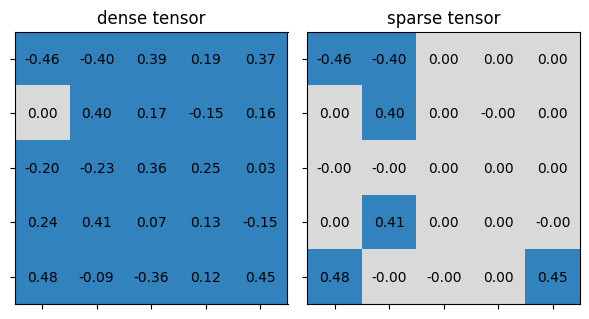

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [49]:
test_fine_grained_prune()

The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of target_sparsity in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning

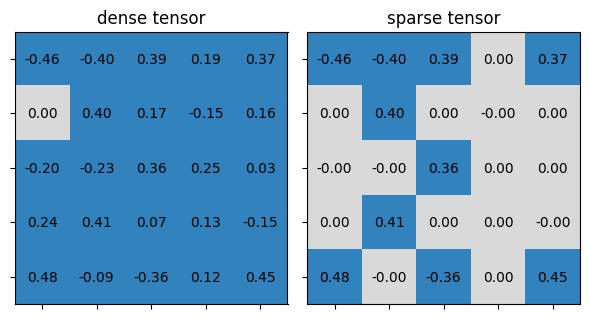

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [50]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = (15/25) # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class FineGrainedPruner, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

In [53]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 3: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity scan 

In [54]:
named_conv_weights = [name for (name, param) \
                          in model.named_parameters() if param.dim() > 3]

print(len(named_conv_weights))
named_conv_weights

28


['backbone.embeddings.patch_embeddings.projection.weight',
 'neck.convs.0.weight',
 'neck.convs.1.weight',
 'neck.convs.2.weight',
 'neck.convs.3.weight',
 'neck.fusion_stage.layers.0.projection.weight',
 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight',
 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight',
 'neck.fusion_stage.layers.0.residual_layer2.convolution1.weight',
 'neck.fusion_stage.layers.0.residual_layer2.convolution2.weight',
 'neck.fusion_stage.layers.1.projection.weight',
 'neck.fusion_stage.layers.1.residual_layer1.convolution1.weight',
 'neck.fusion_stage.layers.1.residual_layer1.convolution2.weight',
 'neck.fusion_stage.layers.1.residual_layer2.convolution1.weight',
 'neck.fusion_stage.layers.1.residual_layer2.convolution2.weight',
 'neck.fusion_stage.layers.2.projection.weight',
 'neck.fusion_stage.layers.2.residual_layer1.convolution1.weight',
 'neck.fusion_stage.layers.2.residual_layer1.convolution2.weight',
 'neck.fusion_stage.layers.2

In [58]:

@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 3]
    named_conv_weights = named_conv_weights[:4]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = eval_fn(model, test_dataloader)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: ssi loss={acc:.2f}', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: ssi loss=[{", ".join(["{:.2f}".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [59]:
sparsities, accuracies = sensitivity_scan(
    model, test_dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/4 weight - backbone.embeddings.patch_embeddings.projection.weight:  17%|█▋        | 1/6 [01:57<09:47, 117.52s/it]

    sparsity=0.40: ssi loss=0.04

scanning 0/4 weight - backbone.embeddings.patch_embeddings.projection.weight:  33%|███▎      | 2/6 [03:55<07:50, 117.53s/it]

    sparsity=0.50: ssi loss=0.05

scanning 0/4 weight - backbone.embeddings.patch_embeddings.projection.weight:  50%|█████     | 3/6 [05:49<05:48, 116.21s/it]

    sparsity=0.60: ssi loss=0.08

scanning 0/4 weight - backbone.embeddings.patch_embeddings.projection.weight:  67%|██████▋   | 4/6 [07:44<03:50, 115.47s/it]

    sparsity=0.70: ssi loss=0.08

scanning 0/4 weight - backbone.embeddings.patch_embeddings.projection.weight:  83%|████████▎ | 5/6 [09:37<01:54, 114.65s/it]

    sparsity=0.80: ssi loss=0.09

scanning 0/4 weight - backbone.embeddings.patch_embeddings.projection.weight: 100%|██████████| 6/6 [11:30<00:00, 115.16s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: ssi loss=[0.04, 0.05, 0.08, 0.08, 0.09, 0.10]

scanning 1/4 weight - neck.convs.0.weight:  17%|█▋        | 1/6 [01:53<09:26, 113.35s/it]

    sparsity=0.40: ssi loss=0.03

scanning 1/4 weight - neck.convs.0.weight:  33%|███▎      | 2/6 [03:47<07:34, 113.66s/it]

    sparsity=0.50: ssi loss=0.03

scanning 1/4 weight - neck.convs.0.weight:  50%|█████     | 3/6 [05:40<05:40, 113.60s/it]

    sparsity=0.60: ssi loss=0.03

scanning 1/4 weight - neck.convs.0.weight:  67%|██████▋   | 4/6 [07:34<03:47, 113.78s/it]

    sparsity=0.70: ssi loss=0.03

scanning 1/4 weight - neck.convs.0.weight:  83%|████████▎ | 5/6 [09:28<01:53, 113.76s/it]

    sparsity=0.80: ssi loss=0.03

scanning 1/4 weight - neck.convs.0.weight: 100%|██████████| 6/6 [11:21<00:00, 113.64s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: ssi loss=[0.03, 0.03, 0.03, 0.03, 0.03, 0.03]

scanning 2/4 weight - neck.convs.1.weight:  17%|█▋        | 1/6 [01:54<09:30, 114.01s/it]

    sparsity=0.40: ssi loss=0.03

scanning 2/4 weight - neck.convs.1.weight:  33%|███▎      | 2/6 [03:49<07:38, 114.62s/it]

    sparsity=0.50: ssi loss=0.03

scanning 2/4 weight - neck.convs.1.weight:  50%|█████     | 3/6 [05:43<05:44, 114.69s/it]

    sparsity=0.60: ssi loss=0.03

scanning 2/4 weight - neck.convs.1.weight:  67%|██████▋   | 4/6 [07:40<03:51, 115.52s/it]

    sparsity=0.70: ssi loss=0.03

scanning 2/4 weight - neck.convs.1.weight:  83%|████████▎ | 5/6 [09:38<01:56, 116.22s/it]

    sparsity=0.80: ssi loss=0.03

scanning 2/4 weight - neck.convs.1.weight: 100%|██████████| 6/6 [11:34<00:00, 115.77s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: ssi loss=[0.03, 0.03, 0.03, 0.03, 0.03, 0.03]

scanning 3/4 weight - neck.convs.2.weight:  17%|█▋        | 1/6 [01:56<09:42, 116.51s/it]

    sparsity=0.40: ssi loss=0.03

scanning 3/4 weight - neck.convs.2.weight:  33%|███▎      | 2/6 [03:53<07:47, 116.83s/it]

    sparsity=0.50: ssi loss=0.03

scanning 3/4 weight - neck.convs.2.weight:  50%|█████     | 3/6 [05:50<05:50, 116.78s/it]

    sparsity=0.60: ssi loss=0.03

scanning 3/4 weight - neck.convs.2.weight:  67%|██████▋   | 4/6 [07:47<03:53, 116.98s/it]

    sparsity=0.70: ssi loss=0.03

scanning 3/4 weight - neck.convs.2.weight:  83%|████████▎ | 5/6 [09:45<01:57, 117.14s/it]

    sparsity=0.80: ssi loss=0.03

scanning 3/4 weight - neck.convs.2.weight: 100%|██████████| 6/6 [11:40<00:00, 116.71s/it]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: ssi loss=[0.03, 0.03, 0.03, 0.03, 0.03, 0.03]

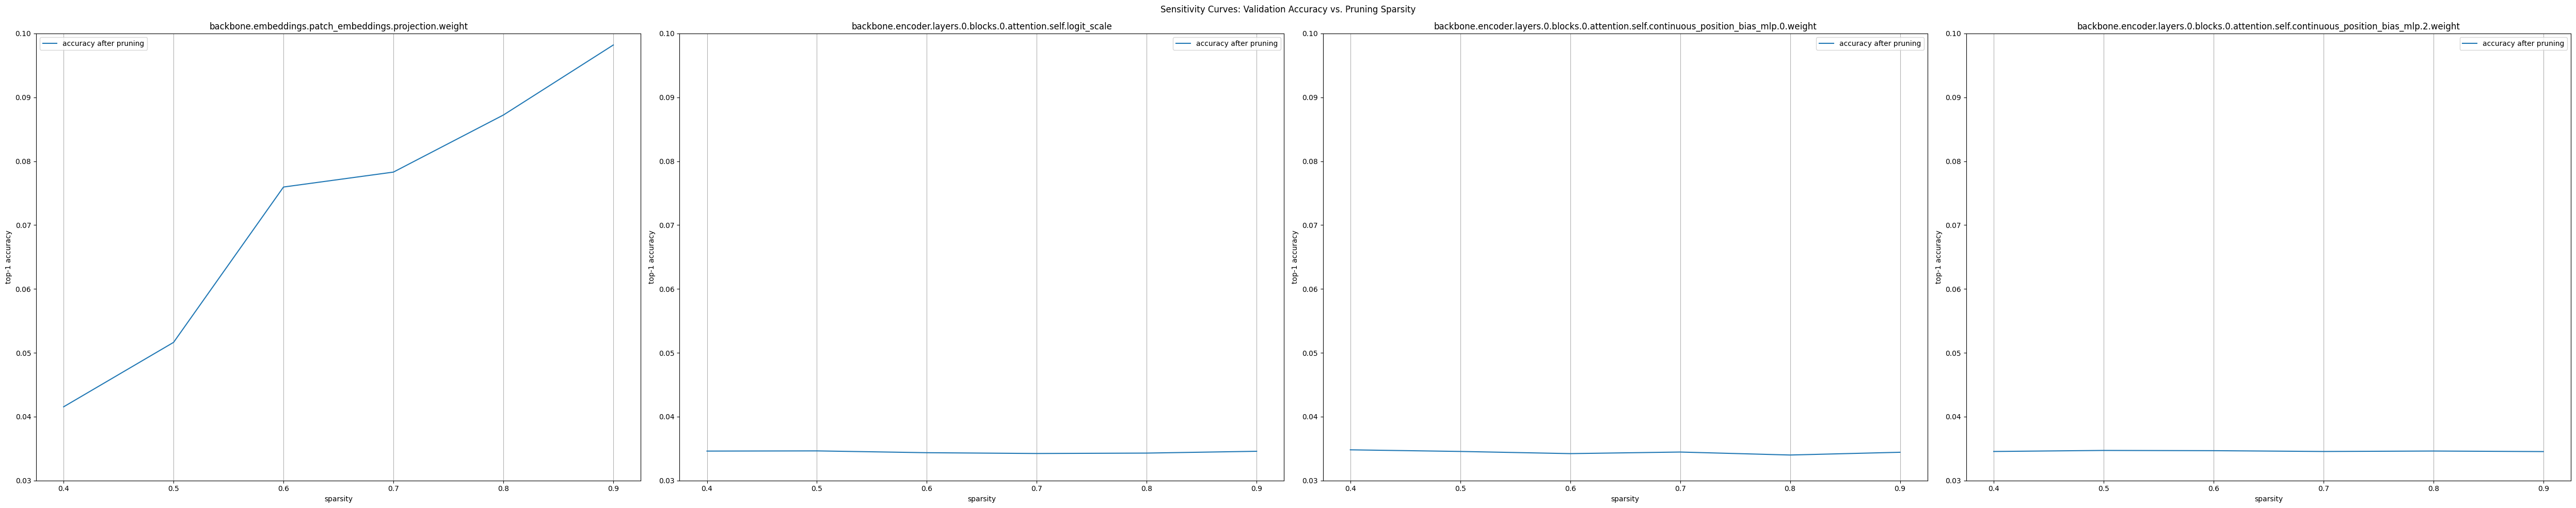

In [82]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(1,4,figsize=(50,10))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            if plot_index == 4:
                break
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(0.03, 0.1)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.savefig('sparsity_accuracy.png')
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

## Parameters of each layer

In [65]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(10 * 15, 6 * 10))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.savefig('num_of_param.png')
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and #Parameters Distribution

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning

In [66]:
recover_model()

<All keys matched successfully>

In [67]:
sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'backbone.embeddings.patch_embeddings.projection.weight': 0,
    'neck.convs.0.weight':0.9,
    'neck.convs.1.weight':0.9,
    'neck.convs.2.weight':0.9,
    'neck.convs.3.weight':0.8,
    'neck.fusion_stage.layers.0.projection.weight':0.8,
    'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight':0.9,
    'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight':0.9,
    'neck.fusion_stage.layers.0.residual_layer2.convolution1.weight':0.7,
    'neck.fusion_stage.layers.0.residual_layer2.convolution2.weight':0.9,
    'neck.fusion_stage.layers.1.projection.weight':0.7,
    'neck.fusion_stage.layers.1.residual_layer1.convolution1.weight':0.9,
    'neck.fusion_stage.layers.1.residual_layer1.convolution2.weight':0.8,
    'neck.fusion_stage.layers.1.residual_layer2.convolution1.weight':0.9,
    'neck.fusion_stage.layers.1.residual_layer2.convolution2.weight':0.9,
    'neck.fusion_stage.layers.2.projection.weight':0.9,
    'neck.fusion_stage.layers.2.residual_layer1.convolution1.weight':0.9,
    'neck.fusion_stage.layers.2.residual_layer1.convolution2.weight':0.7,
    'neck.fusion_stage.layers.2.residual_layer2.convolution1.weight':0.9,
    'neck.fusion_stage.layers.2.residual_layer2.convolution2.weight':0.9,
    'neck.fusion_stage.layers.3.projection.weight':0.9,
    'neck.fusion_stage.layers.3.residual_layer1.convolution1.weight':0.8,
    'neck.fusion_stage.layers.3.residual_layer1.convolution2.weight':0.9,
    'neck.fusion_stage.layers.3.residual_layer2.convolution1.weight':0.9,
    'neck.fusion_stage.layers.3.residual_layer2.convolution2.weight':0.6,
    'head.head.0.weight':0.7,
    'head.head.2.weight':0.7,
    'head.head.4.weight':0.6
##################### YOUR CODE ENDS HERE #######################
}

In [68]:
pruner = FineGrainedPruner(model, sparsity_dict)

In [69]:
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = eval_fn(model, test_dataloader)
print(f"Sparse model has ssi loss ={sparse_model_accuracy:.2f} before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

After pruning with sparsity dictionary
  backbone.embeddings.patch_embeddings.projection.weight: 0.00
  neck.convs.0.weight: 0.90
  neck.convs.1.weight: 0.90
  neck.convs.2.weight: 0.90
  neck.convs.3.weight: 0.80
  neck.fusion_stage.layers.0.projection.weight: 0.80
  neck.fusion_stage.layers.0.residual_layer1.convolution1.weight: 0.90
  neck.fusion_stage.layers.0.residual_layer1.convolution2.weight: 0.90
  neck.fusion_stage.layers.0.residual_layer2.convolution1.weight: 0.70
  neck.fusion_stage.layers.0.residual_layer2.convolution2.weight: 0.90
  neck.fusion_stage.layers.1.projection.weight: 0.70
  neck.fusion_stage.layers.1.residual_layer1.convolution1.weight: 0.90
  neck.fusion_stage.layers.1.residual_layer1.convolution2.weight: 0.80
  neck.fusion_stage.layers.1.residual_layer2.convolution1.weight: 0.90
  neck.fusion_stage.layers.1.residual_layer2.convolution2.weight: 0.90
  neck.fusion_stage.layers.2.projection.weight: 0.90
  neck.fusion_stage.layers.2.residual_layer1.convolution1.w

## Finetune the fine-grained pruned model

In [70]:
pruner.masks.keys()

dict_keys(['backbone.embeddings.patch_embeddings.projection.weight', 'neck.convs.0.weight', 'neck.convs.1.weight', 'neck.convs.2.weight', 'neck.convs.3.weight', 'neck.fusion_stage.layers.0.projection.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer2.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer2.convolution2.weight', 'neck.fusion_stage.layers.1.projection.weight', 'neck.fusion_stage.layers.1.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.1.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.1.residual_layer2.convolution1.weight', 'neck.fusion_stage.layers.1.residual_layer2.convolution2.weight', 'neck.fusion_stage.layers.2.projection.weight', 'neck.fusion_stage.layers.2.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.2.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.2.residua

In [71]:
trainer = Trainer(config, pruner)
trainer.train(train_dataloader, val_dataloader)

device: cuda
Epoch  1


Validation: 100%|██████████| 504/504 [00:49<00:00, 10.25it/s, validation_loss=0.0338]


Model saved at : models/DPTForDepthEstimation
Epoch  2


Validation: 100%|██████████| 504/504 [00:37<00:00, 13.36it/s, validation_loss=0.0309]


Model saved at : models/DPTForDepthEstimation
Epoch  3


Validation: 100%|██████████| 504/504 [00:37<00:00, 13.43it/s, validation_loss=0.0303]


Model saved at : models/DPTForDepthEstimation
Finished Training


In [72]:
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = eval_fn(model, test_dataloader)
print(f"Sparse model has ssi loss={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=113.34 MiB = 72.59% of dense model size
Sparse model has ssi loss=0.03% after fintuning


In [ ]:
PATH = "/kaggle/working/DPTForDepthEstimation-ssi-pruning-conv.pt"
torch.save(model.state_dict(), PATH)

In [ ]:
!zip -r file.zip /kaggle/working/DPTForDepthEstimation-ssi-pruning-conv.pt

In [ ]:
!ls

In [ ]:
from IPython.display import FileLink

name = r'dpt-tiny-pruning-weight.zip'
FileLink(name)

In [ ]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'file.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [ ]:
zip_dir(file_name=name)

# Channel Pruning

### VGG model

In [83]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [84]:
class VGG(nn.Module):
    ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

    def __init__(self) -> None:
        super().__init__()

        layers = []
        counts = defaultdict(int)

        def add(name: str, layer: nn.Module) -> None:
            layers.append((f"{name}{counts[name]}", layer))
            counts[name] += 1

        in_channels = 3
        for x in self.ARCH:
            if x != 'M':
                # conv-bn-relu
                add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
                add("bn", nn.BatchNorm2d(x))
                add("relu", nn.ReLU(True))
                in_channels = x
            else:
                # maxpool
                add("pool", nn.MaxPool2d(2))

        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
        x = self.backbone(x)

        # avgpool: [N, 512, 2, 2] => [N, 512]
        x = x.mean([2, 3])

        # classifier: [N, 512] => [N, 10]
        x = self.classifier(x)
        return x

In [85]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
    model.train()

    for inputs, targets in tqdm(dataloader, desc='train', leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Reset the gradients (from the last iteration)
        optimizer.zero_grad()

        # Forward inference
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward propagation
        loss.backward()

        # Update optimizer and LR scheduler
        optimizer.step()
        scheduler.step()

        if callbacks is not None:
            for callback in callbacks:
                callback()

In [86]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
    model.eval()

    num_samples = 0
    num_correct = 0

    for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Inference
        outputs = model(inputs)

        # Convert logits to class indices
        outputs = outputs.argmax(dim=1)

        # Update metrics
        num_samples += targets.size(0)
        num_correct += (outputs == targets).sum()

    return (num_correct / num_samples * 100).item()

In [87]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

Downloading: "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth" to ./vgg.cifar.pretrained.pth


=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [88]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
    dataset[split] = CIFAR10(
        root="data/cifar10",
        train=(split == "train"),
        download=True,
        transform=transforms[split],
      )
dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(
        dataset[split],
        batch_size=512,
        shuffle=(split == 'train'),
        num_workers=0,
        pin_memory=True,
      )

100%|██████████| 170498071/170498071 [00:16<00:00, 10076801.02it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


 we will implement the channel pruning. Channel pruning removes an entire channel, so that it can achieve inference speed up on existing hardware like GPUs. Similarly, we remove the channels whose weights are of smaller magnitudes (measured by Frobenius norm)

In [89]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

dense model has accuracy=92.95%


## Remove Channel Weights|

In [90]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return int(round((1-prune_ratio)*channels))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
        ##################### YOUR CODE ENDS HERE #####################

    print("Tensor's shape has been changed, but the print info of model doesn't change.")
    return model

Cắt tỉa

following functions for sorting the weight tensor based on the Frobenius norm

To calculate Frobenius norm of a tensor, Pytorch provides torch.norm APIs<br>

In [91]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return int(round((1-prune_ratio)*channels))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
        ##################### YOUR CODE ENDS HERE #####################

    print("Tensor's shape has been changed, but the print info of model doesn't change.")
    return model


In [92]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)

In [93]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

Tensor's shape has been changed, but the print info of model doesn't change.
* Check passed. Right MACs for the pruned model.


In [94]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

pruned model has accuracy=28.14%


## ranking

In [95]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.norm(channel_weight, p=2)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

In [96]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


dense model has accuracy=92.95%
After sorting...


sorted model has accuracy=92.95%
* Check passed.


As you can see, the channel sorting can slightly improve the pruned model's accuracy, but there is still a huge degrade, which is quite common for channel pruning. But luckily, we can perform fine-tuning to recover the accuracy

In [97]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

 * Without sorting...
Tensor's shape has been changed, but the print info of model doesn't change.


pruned model has accuracy=28.14%
 * With sorting...
Tensor's shape has been changed, but the print info of model doesn't change.


pruned model has accuracy=36.81%


In [98]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Epoch 1 Accuracy 91.50% / Best Accuracy: 91.50%


Epoch 2 Accuracy 91.96% / Best Accuracy: 91.96%


Epoch 3 Accuracy 92.01% / Best Accuracy: 92.01%


Epoch 4 Accuracy 92.33% / Best Accuracy: 92.33%


Epoch 5 Accuracy 92.35% / Best Accuracy: 92.35%


# Measure acceleration from pruning

After fine-tuning, the model almost recovers the accuracy. You may have already learned that channel pruning is usually more difficult to recover accuracy compared to fine-grained pruning. However, it directly leads to a smaller model size and smaller computation without specialized model format. It can also run faster on GPUs. Now we compare the model size, computation, and latency of the pruned model.

In [99]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    11.7            7.5             1.6            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            
